In [1]:
import pandas as pd

%load_ext autoreload
%autoreload 2

In [2]:
import torch

from config.model_config import ModelConfig
from config.experiment_config import ExperimentConfig, AvailableDatasets
from vol_predict.features.preprocessor import OneToOnePreprocessor
from vol_predict.loss.loss import Loss

from vol_predict.models.dl.transformer_predictor import TransformerPredictor as Model
from vol_predict.models.dl.lstm_softplus_predictor import (
    LSTMSoftplusPredictor as Baseline,
)

from run import run_backtest, initialize_sequential_runner

In [3]:
config = ExperimentConfig()
config.DATASET = AvailableDatasets.BITCOIN

model_params = ModelConfig()
baseline_params = ModelConfig()

model_params.n_features = 1200
model_params.n_unique_features = 10

# Handles the features
feature_processor = OneToOnePreprocessor()

runner = initialize_sequential_runner(
    model_config=model_params,
    preprocessor=feature_processor,
    experiment_config=config,
)

Available data from 2018-06-04 23:00:00 to 2018-09-30 21:00:00


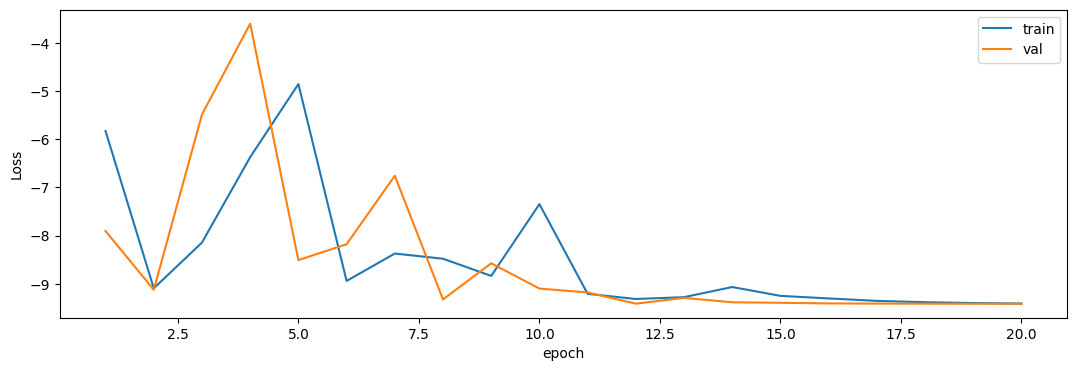

In [4]:
runner.model_config.lr = 1e-2
runner.model_config.n_epochs = 20
runner.model_config.hidden_size = 64
runner.model_config.n_layers = 3
runner.model_config.batch_size = 16
runner.model_config.optimizer = torch.optim.Adam
runner.model_config.loss = Loss.NLL
runner.model_config.dropout = 0.20

result = run_backtest(
    model_cls=Model,
    baseline_cls=Baseline,
    runner=runner,
)

In [5]:
result

(            model_loss  baseline_loss  \
 datetime                                
 2018-06-30    3.300417      -9.311248   
 2018-07-05   -9.749785      -9.432842   
 2018-07-10   -8.714493      -9.532697   
 2018-07-15   -8.441457      -8.470949   
 2018-07-20   -0.248279      -9.336910   
 2018-07-25   -0.331198      -9.153780   
 2018-07-30   -8.703309      -8.813708   
 2018-08-04   -0.380213      -8.748906   
 2018-08-09   -8.332642      -8.250985   
 2018-08-14   -8.794457      -8.836077   
 2018-08-19   -0.406665      -8.784204   
 2018-08-24   -8.606632      -9.418982   
 2018-08-29   -8.826902      -9.500373   
 2018-09-03   -8.374510      -8.650947   
 2018-09-08   -9.259411      -9.413382   
 2018-09-13   -8.891021      -9.785989   
 2018-09-18   -0.380188      -9.229443   
 2018-09-23    2.882871      -9.864740   
 2018-09-28   -0.406698      -9.808557   
 
                                                  true_returns  \
 datetime                                         

In [7]:
from sklearn.metrics import root_mean_squared_error

rmse = []
for date, row in result[0].iterrows():
    rmse.append(
        [
            date,
            root_mean_squared_error(row.true_vols, row.model_preds),
            root_mean_squared_error(row.true_vols, row.baseline_preds),
        ]
    )

rmse = pd.DataFrame(rmse, columns=["date", "model", "baseline"]).set_index("date")

In [8]:
rmse.mean(axis=0)

model       2.588841
baseline    0.000199
dtype: float64

In [9]:
rmse.std(axis=0)

model       7.189781
baseline    0.000156
dtype: float64

In [11]:
result[0].to_csv(f"Daily_Transf_results_{runner.model_config.n_epochs}.csv")